# The code conducts Time Series analysis using XGBoost Regression to predict the prevalence of moderate or severe household food insecurity.

In [1074]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


In [1075]:
df = pd.read_csv('/Users/sedastepanyan/Downloads/Household_surveys.csv', usecols=['survey_date', 'p_mod'])
df = df.set_index('survey_date')
df.index = pd.to_datetime(df.index, format="%m/%d/%Y %I:%M:%S %p", errors='coerce')


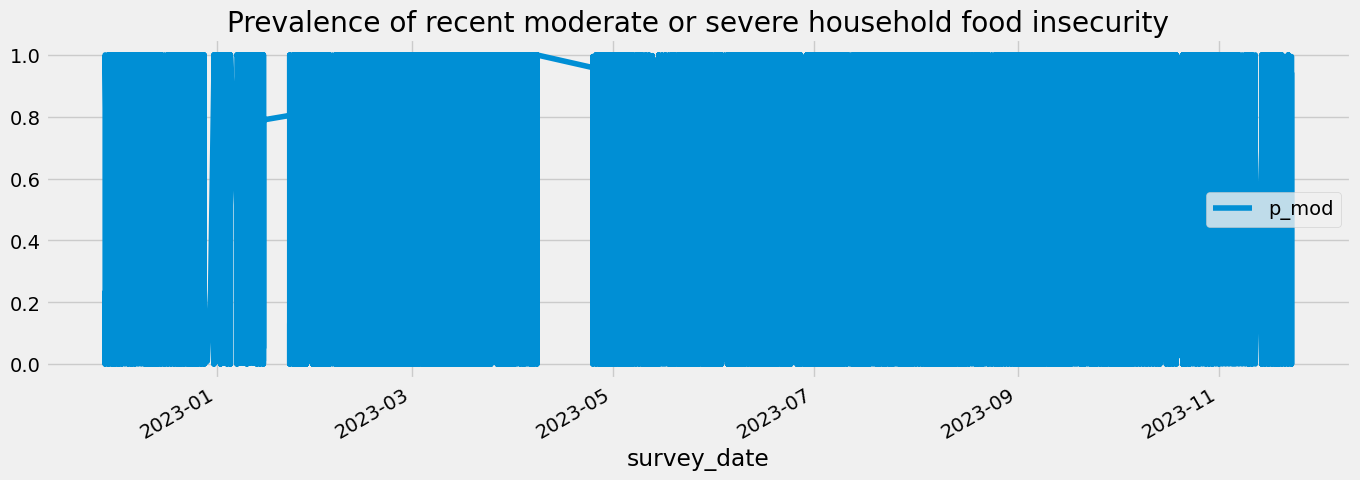

In [1076]:
df.plot(figsize=(15, 5),
        color=color_pal[0],
        title='Prevalence of recent moderate or severe household food insecurity')
plt.show()

## Check and Remove data gaps

In [1077]:
df = df.sort_index()  # Make sure the DataFrame is sorted by 'survey_date'

# Generate a sequence of consecutive dates
full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Check for missing dates
missing_dates = full_date_range[~full_date_range.isin(df.index)]

if missing_dates.empty:
    print("Data is collected for every single day.")
else:
    print("There are gaps in the data. Missing dates:", missing_dates)

There are gaps in the data. Missing dates: DatetimeIndex(['2023-01-06', '2023-01-16', '2023-01-17', '2023-01-18',
               '2023-01-19', '2023-01-20', '2023-01-21', '2023-01-22',
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16',
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-11-13'],
              dtype='datetime64[ns]', freq=None)


In [1078]:
# Use the isin method to create a boolean mask
mask = ~df.index.isin(missing_dates)

# Use the mask to filter the DataFrame
df = df[mask]

In [1079]:
# Drop duplicates in case there are any
df = df[~df.index.duplicated(keep='first')]

# Specify the frequency (assuming daily data, change it according to your data)
freq = 'D'

# Reindex the DataFrame with the specified frequency
df = df.asfreq(freq)


In [1080]:
# Check for missing dates one more time
missing_dates = full_date_range[~full_date_range.isin(df.index)]

if missing_dates.empty:
    print("Data is collected for every single day.")
else:
    print("There are gaps in the data. Missing dates:", missing_dates)

Data is collected for every single day.


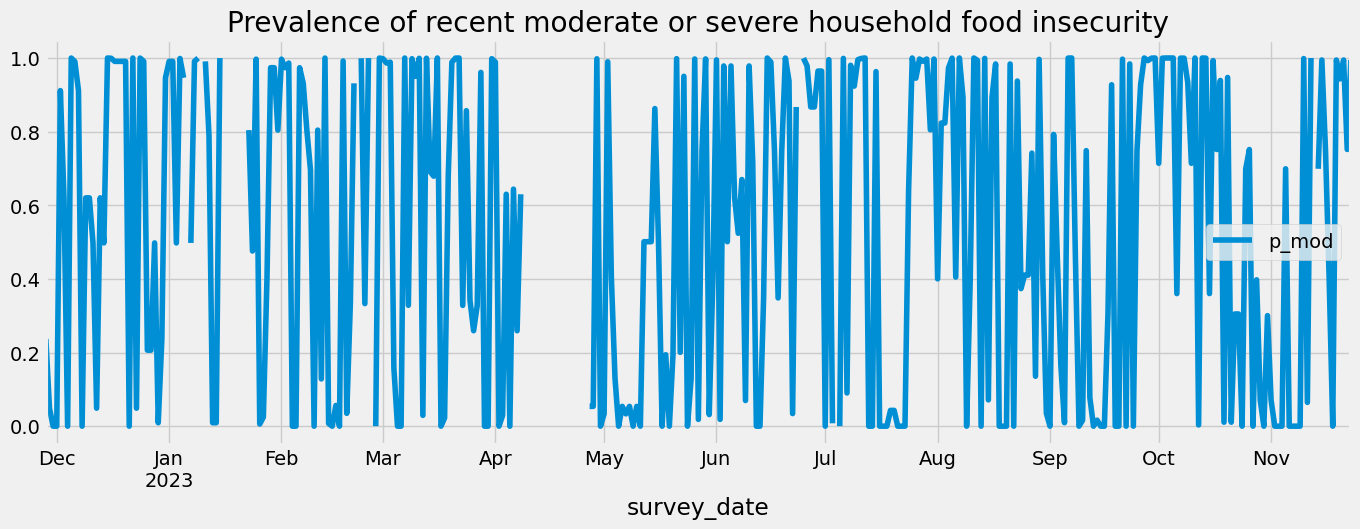

In [1081]:
#Plot once more and make sure that there are no data gaps
df.plot(figsize=(15, 5),
        color=color_pal[0],
        title='Prevalence of recent moderate or severe household food insecurity')
plt.show()

## 1. Outlier analysis and removal

count    330.000000
mean       0.536226
std        0.421790
min        0.000000
25%        0.033410
50%        0.625029
75%        0.988870
max        1.000000
Name: p_mod, dtype: float64

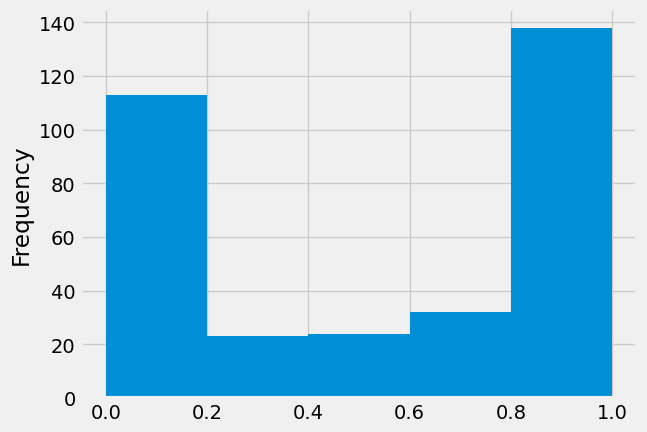

In [1082]:
df['p_mod'].plot(kind='hist', bins=5)
df['p_mod'].describe()

In [1083]:
df.index.min()

Timestamp('2022-11-28 00:00:00')

In [1084]:
df.index.max()

Timestamp('2023-11-23 00:00:00')

## Reviewing: Train / Test Split

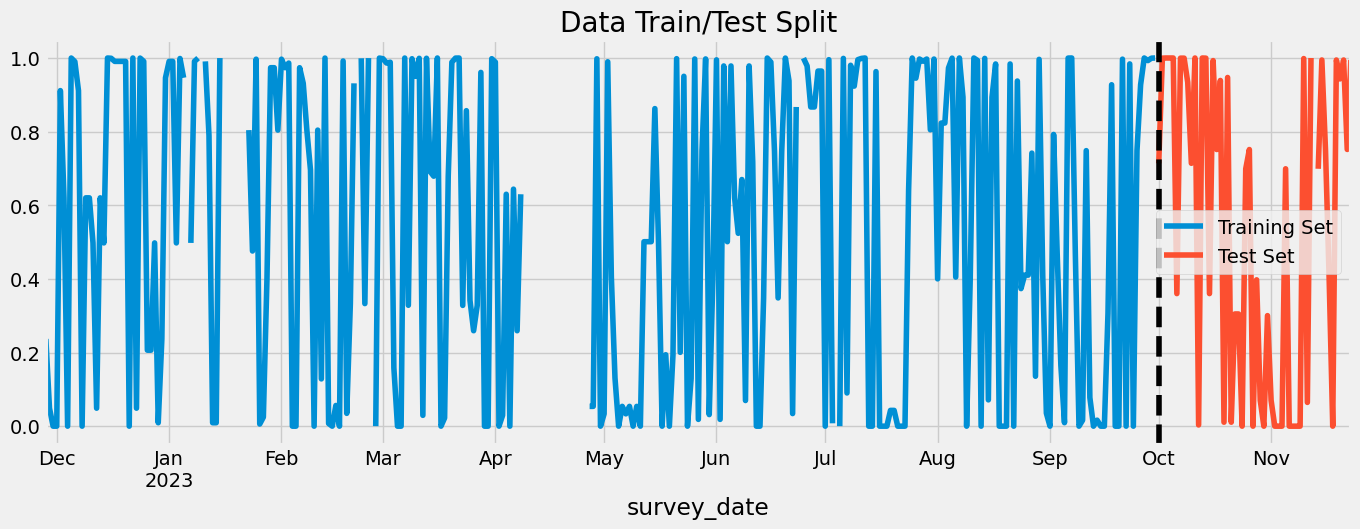

In [1085]:
train = df.loc[df.index < '10-01-2023']
test = df.loc[df.index >= '10-01-2023']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('10-01-2023', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## 1. Time Series Cross Validation

In [1086]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()

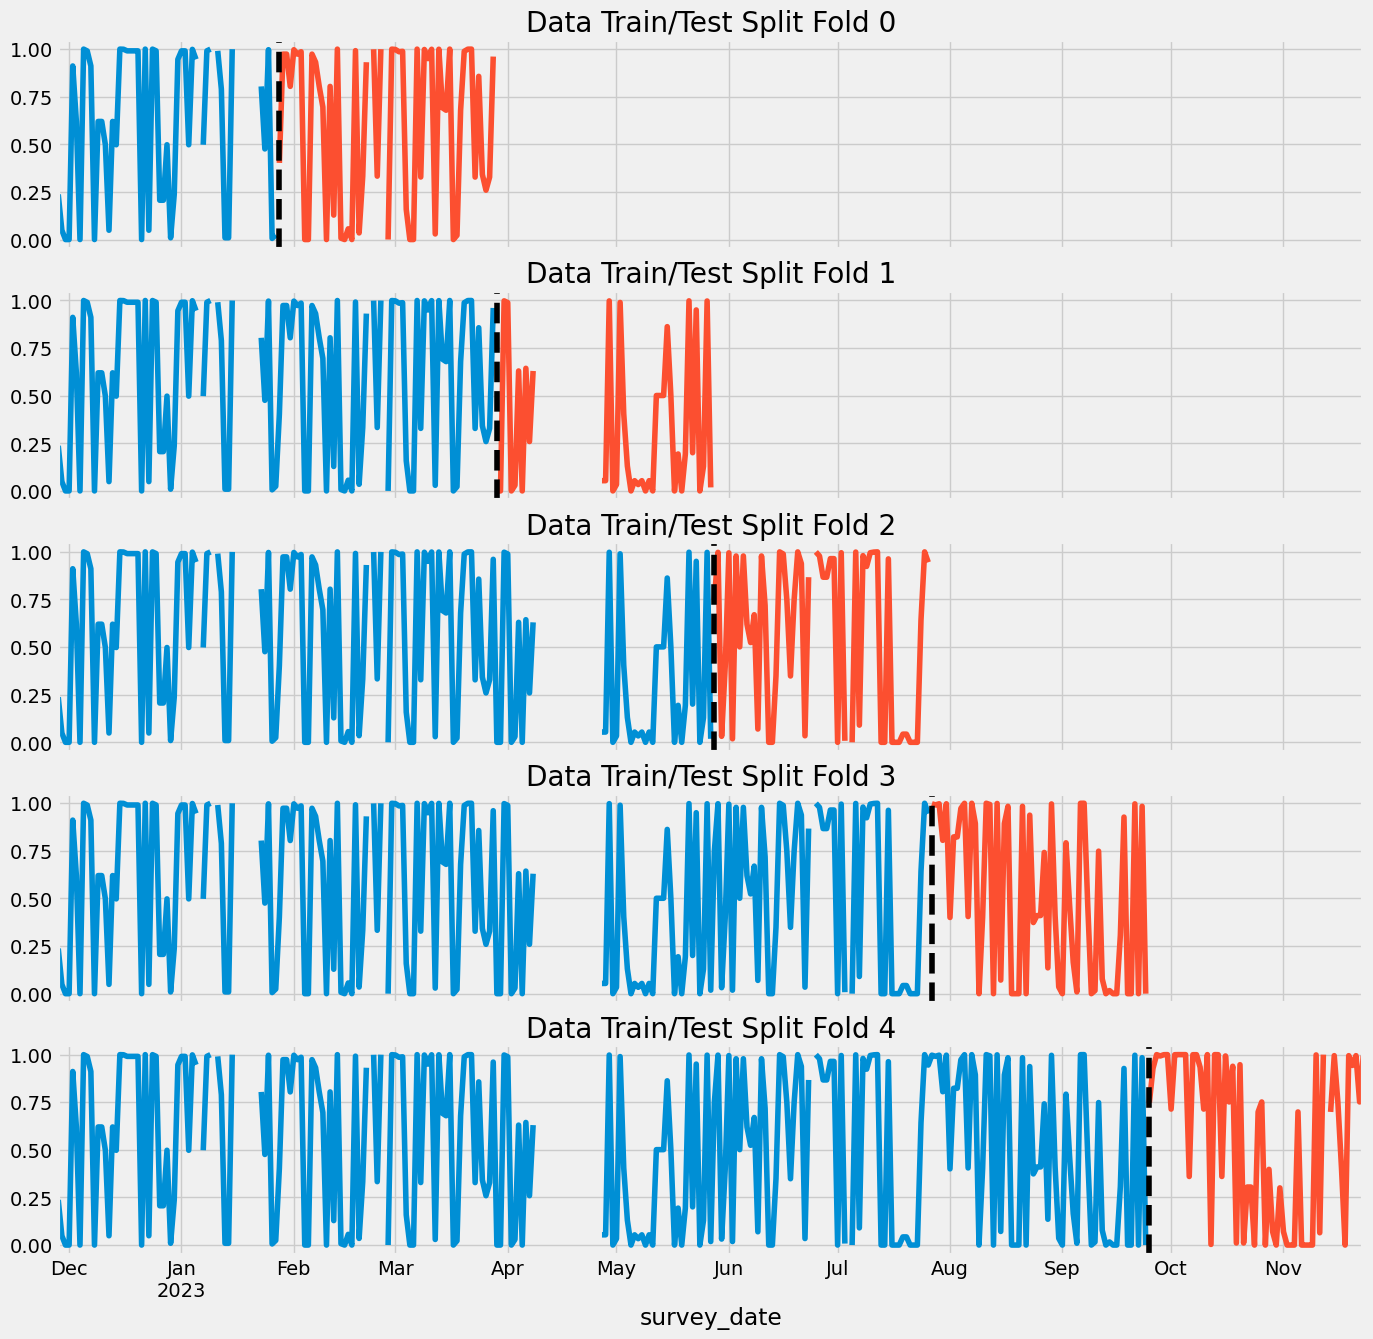

In [1087]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['p_mod'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['p_mod'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [1088]:
#time_diff = df.index.to_series().diff()

# Display unique time differences and their counts
#print(time_diff.value_counts())

## 2. Forecasting Horizon Explained
##### The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).

In [1089]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

## 3. Lag Features

In [1090]:
def add_lags(df):
    target_map = df['p_mod'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('60 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('120 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('180 days')).map(target_map)
    return df

df = add_lags(df)

## Train Using Cross Validation

In [1091]:
tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'p_mod'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
 # Remove rows with NaN or Infinity values in both X_train and y_train
    invalid_rows = np.isnan(y_train) | np.isinf(y_train)
    X_train = X_train[~invalid_rows]
    y_train = y_train[~invalid_rows]

    # Replace NaN or Infinity values in X_train with the mean
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train.fillna(X_train.mean(), inplace=True)  # or use another imputation method

    # Handle NaN or Infinity values in the testing set
    X_test = test[FEATURES]
    y_test = test[TARGET]

    invalid_rows_test = np.isnan(y_test) | np.isinf(y_test)
    X_test = X_test[~invalid_rows_test]
    y_test = y_test[~invalid_rows_test]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:0.41429	validation_1-rmse:0.42652
[50]	validation_0-rmse:0.36380	validation_1-rmse:0.47456
[0]	validation_0-rmse:0.42045	validation_1-rmse:0.41294
[49]	validation_0-rmse:0.39897	validation_1-rmse:0.42410
[0]	validation_0-rmse:0.41771	validation_1-rmse:0.43086
[56]	validation_0-rmse:0.38491	validation_1-rmse:0.43628
[0]	validation_0-rmse:0.42156	validation_1-rmse:0.42260
[68]	validation_0-rmse:0.39502	validation_1-rmse:0.42292
[0]	validation_0-rmse:0.42184	validation_1-rmse:0.42520
[49]	validation_0-rmse:0.40476	validation_1-rmse:0.43223


In [1092]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.4231
Fold scores:[0.4265228987362291, 0.4129366944004101, 0.43084844497261937, 0.4199224454915205, 0.42519511870974697]


## 4. Predicting the Future

#### Retraining on all data
#### To Predict the future we need an emtpy dataframe for future date ranges.
#### Run those dates through our feature creation code + lag creation

In [1093]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'p_mod'

X_all = df[FEATURES]
y_all = df[TARGET]

df_cleaned = df.dropna(subset=[TARGET])

# Separate cleaned features and target
X_all_cleaned = df_cleaned[FEATURES]
y_all_cleaned = df_cleaned[TARGET]

# Check if indices are unique
if not df_cleaned.index.is_unique:
    df_cleaned.reset_index(drop=True, inplace=True)  # Reset index if not unique

# Retrain the XGBoost model on the cleaned data
reg = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=500,
    objective='reg:squarederror',
    max_depth=3,
    learning_rate=0.01
)

reg.fit(X_all_cleaned, y_all_cleaned, eval_set=[(X_all_cleaned, y_all_cleaned)], verbose=100)

[0]	validation_0-rmse:0.42242
[100]	validation_0-rmse:0.39329
[200]	validation_0-rmse:0.37412
[300]	validation_0-rmse:0.35681
[400]	validation_0-rmse:0.34228
[499]	validation_0-rmse:0.32964


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [1094]:
# Create future dataframe
future = pd.date_range('2023-11-24','2024-02-23', freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [1095]:
future_w_features = df_and_future.query('isFuture').copy()

## Predict the future

In [1096]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

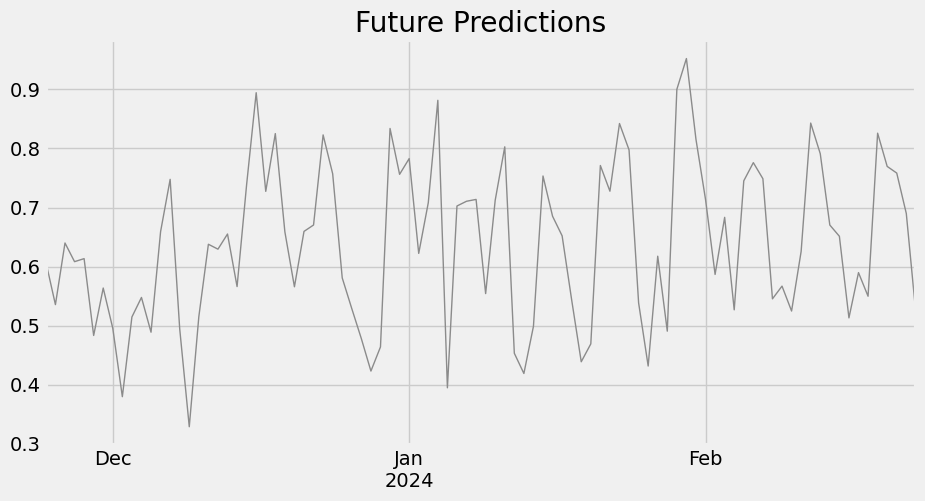

In [1097]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [1098]:

df['p_mod'].mean()

0.5362263329393939

In [1099]:
future_w_features['pred'].mean()

0.6379667

In [1102]:
#df[(df.index > '2023-11-24' & df.index <= '2024-02-23')]

In [1106]:
#Accuracy
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
# force scores to be positive
#scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (score.mean(), score.std()) )

Mean MAE: 0.425 (0.000)
